## Borrow Feautures

看看同样特征的情况下线性模型和梯度提升树的差距。

特征构造脚本的来源：https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm/code

### 导入模块

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
# from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc

### 生成宽表

In [109]:
'''
def build_model_input():
    buro_bal = pd.read_csv('./input/bureau_balance.csv')
    print('Buro bal shape : ', buro_bal.shape)
    
    # print('transform to dummies')
    # buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)
    
    print('Counting buros')
    buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
    buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])
    
    print('averaging buro bal')
    avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()
    avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
    # maxmin_buro_bal = buro_bal.groupby("SK_ID_BUREAU").max() - buro_bal.groupby("SK_ID_BUREAU").min()
    # maxmin_buro_bal.columns = ['maxmin_buro_'+ f_ for f_ in maxmin_buro_bal.columns]
    del buro_bal
    gc.collect()
    
    print('Read Bureau')
    buro = pd.read_csv('./input/bureau.csv')
    buro.columns = ['buro_' + f_ for f_ in buro_full.columns]
    
    # print('Go to dummies')
    # buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
    # buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
    # buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')
    
    # buro_full = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)
    # buro.columns = ['buro_' + f_ for f_ in buro_full.columns]
    
    # del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
    # gc.collect()
    
    print('Merge with buro avg')
    buro_full = buro.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))
    # buro_full = buro_full.merge(right=maxmin_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal_maxmin'))
    
    print('Counting buro per SK_ID_CURR')
    nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
    buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])
    
    print('Averaging bureau')
    avg_buro = buro_full.groupby('SK_ID_CURR').mean()
    print(avg_buro.head())
    
    del buro, buro_full
    gc.collect()
    
    print('Read prev')
    prev = pd.read_csv('./input/previous_application.csv')
    
    #  prev_cat_features = [
    #     f_ for f_ in prev.columns if prev[f_].dtype == 'object'
    # ]
    
    # print('Go to dummies')
    # prev_dum = pd.DataFrame()
    # for f_ in prev_cat_features:
    #     prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)
    
    # prev = pd.concat([prev, prev_dum], axis=1)
    
    del prev_dum
    gc.collect()
    
    print('Counting number of Prevs')
    nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])
    
    print('Averaging prev')
    avg_prev = prev.groupby('SK_ID_CURR').mean()
    print(avg_prev.head())
    del prev
    gc.collect()
    
    print('Reading POS_CASH')
    pos = pd.read_csv('./input/POS_CASH_balance.csv')
    
    # print('Go to dummies')
    # pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)
    
    print('Compute nb of prevs per curr')
    nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    print('Go to averages')
    avg_pos = pos.groupby('SK_ID_CURR').mean()
    
    del pos, nb_prevs
    gc.collect()
    
    print('Reading CC balance')
    cc_bal = pd.read_csv('./input/credit_card_balance.csv')
    
    print('Go to dummies')
    cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')], axis=1)
    
    nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    print('Compute average')
    avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
    avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
    
    del cc_bal, nb_prevs
    gc.collect()
    
    print('Reading Installments')
    inst = pd.read_csv('./input/installments_payments.csv')
    nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    avg_inst = inst.groupby('SK_ID_CURR').mean()
    avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]
    
    print('Read data and test')
    data = pd.read_csv('./input/application_train.csv')
    test = pd.read_csv('./input/application_test.csv')
    print('Shapes : ', data.shape, test.shape)
    
    y = data[["SK_ID_CURR", 'TARGET']]
    del data['TARGET']
    
    # categorical_feats = [
    #     f for f in data.columns if data[f].dtype == 'object'
    #  ]
    # categorical_feats
    # for f_ in categorical_feats:
    #     data[f_], indexer = pd.factorize(data[f_])
    #     test[f_] = indexer.get_indexer(test[f_])
        
    data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    
    del avg_buro, avg_prev
    gc.collect()

    return data, test, y
'''

'\ndef build_model_input():\n    buro_bal = pd.read_csv(\'./input/bureau_balance.csv\')\n    print(\'Buro bal shape : \', buro_bal.shape)\n    \n    # print(\'transform to dummies\')\n    # buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix=\'buro_bal_status\')], axis=1).drop(\'STATUS\', axis=1)\n    \n    print(\'Counting buros\')\n    buro_counts = buro_bal[[\'SK_ID_BUREAU\', \'MONTHS_BALANCE\']].groupby(\'SK_ID_BUREAU\').count()\n    buro_bal[\'buro_count\'] = buro_bal[\'SK_ID_BUREAU\'].map(buro_counts[\'MONTHS_BALANCE\'])\n    \n    print(\'averaging buro bal\')\n    avg_buro_bal = buro_bal.groupby(\'SK_ID_BUREAU\').mean()\n    avg_buro_bal.columns = [\'avg_buro_\' + f_ for f_ in avg_buro_bal.columns]\n    # maxmin_buro_bal = buro_bal.groupby("SK_ID_BUREAU").max() - buro_bal.groupby("SK_ID_BUREAU").min()\n    # maxmin_buro_bal.columns = [\'maxmin_buro_\'+ f_ for f_ in maxmin_buro_bal.columns]\n    del buro_bal\n    gc.collect()\n    \n    print(\'Read Bureau\')\

In [110]:
'''
data ,test, y = build_model_input()
'''

'\ndata ,test, y = build_model_input()\n'

In [108]:
'''
data.to_csv("./input/data_002.csv", index=False)
test.to_csv("./input/test_002.csv", index=False)
y.to_csv("./input/y_002.csv", index=False)
'''

'\ndata.to_csv("./input/data_002.csv", index=False)\ntest.to_csv("./input/test_002.csv", index=False)\ny.to_csv("./input/y_002.csv", index=False)\n'

In [2]:
data = pd.read_csv("./input/data_001.csv")
test = pd.read_csv("./input/test_001.csv")

In [21]:
data.SK_ID_CURR.nunique()

307511

In [4]:
buro_wide = pd.read_csv("./data/buro_wide_002.csv")
buro_full_wide = pd.read_csv("./data/buro_full_wide_004.csv")
pos_wide = pd.read_csv("./data/pos_bal_wide_004.csv")
cc_wide = pd.read_csv("./data/cc_bal_wide_004.csv")

In [30]:
print(buro_full_wide.shape)
print(buro_full_wide.SK_ID_CURR.nunique())
print(buro_wide.shape)
print(buro_wide.SK_ID_CURR.nunique())

(305811, 289)
305811
(305811, 80)
305811


In [5]:
data = data.merge(right=buro_full_wide, how='left', on='SK_ID_CURR')
test = test.merge(right=buro_full_wide, how='left', on='SK_ID_CURR')

del buro_full_wide
gc.collect()

data = data.merge(right=buro_wide, how='left', on='SK_ID_CURR')
test = test.merge(right=buro_wide, how='left', on='SK_ID_CURR')

del buro_wide
gc.collect()

data = data.merge(right=pos_wide, how='left', on='SK_ID_CURR')
test = test.merge(right=pos_wide, how='left', on='SK_ID_CURR')

del pos_wide
gc.collect()

data = data.merge(right=cc_wide, how='left', on='SK_ID_CURR')
test = test.merge(right=cc_wide, how='left', on='SK_ID_CURR')

del cc_wide
gc.collect()

28

In [6]:
data.shape, test.shape

((307511, 917), (48744, 917))

In [7]:
features = list(data.columns)

In [8]:
y = pd.read_csv("./input/y_001.csv")

data_train = data[data.SK_ID_CURR < 130000]
data_val = data[(data.SK_ID_CURR >= 130000) & (data.SK_ID_CURR < 150000)]

ydata_train = y[y.SK_ID_CURR < 130000]
ydata_val = y[(y.SK_ID_CURR >= 130000) & (y.SK_ID_CURR < 150000)]

### 第一个线性模型

In [34]:
features = list(data.columns)
features.remove("SK_ID_CURR")

In [35]:
X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

In [36]:
X_num_train.shape, X_num_val.shape

((25803, 746), (17392, 746))

In [37]:
import preprocessing7 as preprocessing
import score_card4 as score_card
import score_card_fs

In [40]:
X_num_train[np.isnan(X_num_train)] = 0
X_num_val[np.isnan(X_num_val)] = 0

cutter = preprocessing.MPChi2Cutter(init_bin_num=25, max_bin_num=5, max_peak_num=1)
X_cut_train = cutter.fit_transform(X_num_train, y_train)
X_cut_val = cutter.transform(X_num_val)

encoder = preprocessing.MPWOEEncoder(alpha=10)
X_woe_train = encoder.fit_transform(X_cut_train, y_train)
X_woe_val = encoder.transform(X_cut_val)

In [33]:
X_woe_val[np.isnan(X_woe_val)] = 0

In [42]:
np.isnan(X_woe_train).sum()

0

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score

def ks_score(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)
    w = tpr - fpr
    return w.max(), thresholds[np.nanargmax(w)]

clf = LogisticRegression(**{"penalty": "l1", "C": 1.0})
clf.fit(X_woe_train, y_train)

pred_train = clf.predict_proba(X_woe_train)[:,1]
auc_train = roc_auc_score(y_train, pred_train)

pred_val = clf.predict_proba(X_woe_val)[:,1]
auc_val = roc_auc_score(y_val, pred_val)

print("*" * 20 + " MODEL REPORT " + "*" * 20)
print("X-shape-train: {}, X-shape-val: {}".format(X_woe_train.shape, X_woe_val.shape))
print("auc-train: {:.2}, auc-val: {:.2}".format(auc_train, auc_val))
# print("ks-train: {:.2}, ks-val: {:.2}".format(ks_train, ks_val))
# print("maxks-train: {:.2}, maxks-val: {:.2}".format(th_train, th_val))

******************** MODEL REPORT ********************
X-shape-train: (25803, 746), X-shape-val: (17392, 746)
auc-train: 0.8, auc-val: 0.76


### 筛选特征

In [45]:
fs_stack = score_card_fs.FSStack(features)
fs_result = score_card_fs.filter_lasso_sc(X_woe_train, y_train, argv={"penalty": "l1", "C": 1.0})
fs_stack.append("filter0_lasso_sc", fs_result)
fs_result

FSResult(origin_cnt=746, selected_cnt=172, selected=[  0   2   4   7   8  11  12  14  15  16  17  18  19  22  24  26  27  28
  29  30  31  32  35  38  39  40  41  46  49  50  58  74  75  89  90  92
  93 103 106 115 116 117 118 119 128 129 133 147 150 151 157 170 174 178
 179 183 184 185 186 189 190 191 192 193 195 196 204 209 210 215 219 223
 226 228 233 234 241 242 245 246 247 259 264 265 271 274 282 283 287 291
 292 294 295 297 299 301 305 308 309 314 315 317 318 319 320 327 328 329
 331 332 333 334 335 339 340 341 342 346 351 358 359 361 373 376 378 380
 386 387 390 403 407 451 452 455 457 461 462 470 476 509 517 524 526 527
 530 534 535 536 547 585 589 594 598 602 603 605 621 625 653 656 659 668
 701 702 703 709 711 712 721 723 728 745], score=[  6.46680639e-01   0.00000000e+00   2.26540667e-01   0.00000000e+00
   1.60660599e-01   0.00000000e+00   0.00000000e+00   5.14955255e-01
   3.40477133e-01   0.00000000e+00   0.00000000e+00   6.12265311e-01
   1.94678084e-01   0.00000000e+00 

In [46]:
def create_clf():
    return LogisticRegression(**{"penalty": "l1", "C": 1.0})

fs_result = score_card_fs.wrapper_backward_forward_mt(X_woe_train[:, fs_stack.get_latest_ids()], X_woe_val[:, fs_stack.get_latest_ids()], y_train, y_val, create_clf)
fs_stack.append("wrapper0_stepwise", fs_result)

metric stop inproving.


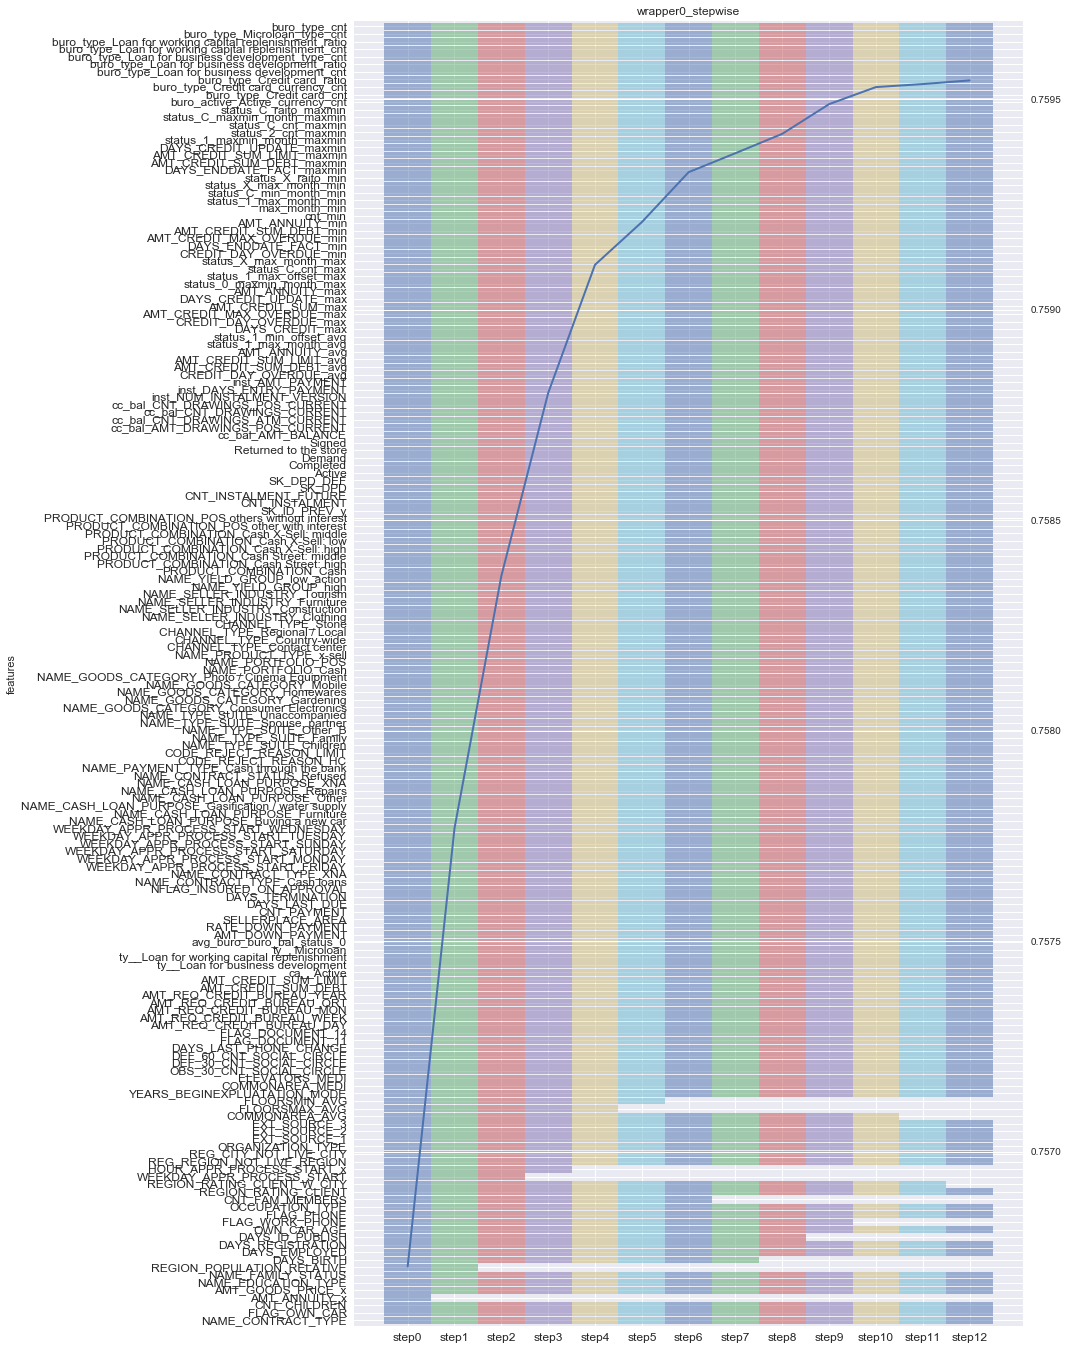

In [47]:
fs_result = fs_stack.get_fsresult(1)
score_card_fs.plot_wrapper_result(fs_result, features=fs_stack.get_selected_names(0), argv={"figsize": (12, 24)})
plt.title(fs_stack.get_fsname(1))
plt.show()

### 验证版

In [48]:
final_features = fs_stack.get_latest_names()
final_ids = fs_stack.get_latest_ids()
# final_features.remove('a_work_distance')
X_woe_train_v = X_woe_train[:, final_ids]
X_woe_val_v = X_woe_val[:, final_ids]

y_train_v = y_train
y_val_v = y_val

# LR
clf = LogisticRegression(**{"penalty": "l1", "C": 1.0})
clf.fit(X_woe_train_v, y_train_v)

pred_train_v = clf.predict_proba(X_woe_train_v)[:,1]
pred_val_v = clf.predict_proba(X_woe_val_v)[:,1]

auc_train_v = roc_auc_score(y_train_v, pred_train_v)
auc_val_v = roc_auc_score(y_val_v, pred_val_v)

ks_train_v, th_train_v = ks_score(y_train_v, pred_train_v)
ks_val_v, th_val_v = ks_score(y_val_v, pred_val_v)

print("*" * 20 + " MODEL REPORT " + "*" * 20)
print("X-shape-train: {}, X-shape-val: {}".format(X_woe_train_v.shape, X_woe_val_v.shape))
print("auc-train: {:.2}, auc-val: {:.2}".format(auc_train_v, auc_val_v))
print("ks-train: {:.2}, ks-val: {:.2}".format(ks_train_v, ks_val_v))
print("maxks-train: {:.2}, maxks-val: {:.2}".format(th_train_v, th_val_v))

print("*" * 20 + " LASSO COEF " + "*" * 20)
for feat_, coef_ in zip(final_features, clf.coef_[0]):
    print("{:>30} : {:.3}".format(feat_, coef_))

******************** MODEL REPORT ********************
X-shape-train: (25803, 160), X-shape-val: (17392, 160)
auc-train: 0.78, auc-val: 0.76
ks-train: 0.43, ks-val: 0.4
maxks-train: 0.075, maxks-val: 0.085
******************** LASSO COEF ********************
            NAME_CONTRACT_TYPE : 0.793
                  FLAG_OWN_CAR : 0.219
                  CNT_CHILDREN : 0.378
             AMT_GOODS_PRICE_x : 0.451
           NAME_EDUCATION_TYPE : 0.617
            NAME_FAMILY_STATUS : 0.133
                 DAYS_EMPLOYED : 0.366
             DAYS_REGISTRATION : 0.22
                   OWN_CAR_AGE : 0.394
                    FLAG_PHONE : 0.508
               OCCUPATION_TYPE : 0.301
          REGION_RATING_CLIENT : 0.42
    REG_REGION_NOT_LIVE_REGION : 0.324
        REG_CITY_NOT_LIVE_CITY : 0.0313
             ORGANIZATION_TYPE : 0.322
                  EXT_SOURCE_1 : 0.503
                  EXT_SOURCE_2 : 0.691
                  EXT_SOURCE_3 : 0.52
  YEARS_BEGINEXPLUATATION_MODE : 0.143
  

In [49]:
fs_stack.get_latest_names()

array(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'CNT_CHILDREN',
       'AMT_GOODS_PRICE_x', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'FLAG_PHONE',
       'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REG_REGION_NOT_LIVE_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'YEARS_BEGINEXPLUATATION_MODE', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_14', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'ca__Active',
       'ty__Loan for business development',
       'ty__Loan for working capital replenishment', 'ty__Microloan',
       'avg_b

### 提交版A

In [50]:
fs_stack.get_latest_names()

array(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'CNT_CHILDREN',
       'AMT_GOODS_PRICE_x', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'FLAG_PHONE',
       'OCCUPATION_TYPE', 'REGION_RATING_CLIENT',
       'REG_REGION_NOT_LIVE_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'YEARS_BEGINEXPLUATATION_MODE', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_14', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'ca__Active',
       'ty__Loan for business development',
       'ty__Loan for working capital replenishment', 'ty__Microloan',
       'avg_b

In [52]:
X_num_sub = test[features].values
X_cut_sub = cutter.transform(X_num_sub)
X_woe_sub = encoder.transform(X_cut_sub)
X_woe_sub[np.isnan(X_woe_sub)] = 0

pred_sub = clf.predict_proba(X_woe_sub[:, fs_stack.get_latest_ids()])[:,1]
test["TARGET"] = pred_sub
# test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-005-A.csv", index=False)

### 提交板B

In [51]:
X_num_all = data[fs_stack.get_latest_names()].values
X_num_sub = test[fs_stack.get_latest_names()].values
y_all = y.TARGET.values

cutter_b = preprocessing.MPChi2Cutter(init_bin_num=25, max_bin_num=5, max_peak_num=1)
X_cut_all = cutter_b.fit_transform(X_num_all, y_all)
X_cut_sub = cutter_b.transform(X_num_sub)

encoder_b = preprocessing.MPWOEEncoder(alpha=10)
X_woe_all = encoder_b.fit_transform(X_cut_all, y_all)
X_woe_sub = encoder_b.transform(X_cut_sub)
X_woe_sub[np.isnan(X_woe_sub)] = 0

clf_b = LogisticRegression(**{"penalty": "l1", "C": 1.0})
clf_b.fit(X_woe_all, y_all)

pred_all = clf_b.predict_proba(X_woe_all)[:,1]
pred_sub = clf_b.predict_proba(X_woe_sub)[:,1]

test["TARGET"] = pred_sub
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-005-B.csv", index=False)

### 提交版C

借一个xgb提交 ： https://www.kaggle.com/kailex/tidy-xgb-0-778/code

In [52]:
xgb_sub = pd.read_csv("./result/tidy_xgb_0.7784.csv")

xgb_sub["TARGET"] = xgb_sub.TARGET.values * .9 + pred_sub * .1
xgb_sub.to_csv("./result/submission-005-C.csv", index=False)

In [53]:
xgb_sub.head()

,SK_ID_CURR,TARGET
0,100001,0.032115
1,100005,0.071988
2,100013,0.015341
3,100028,0.040330
4,100038,0.118955


### 提交版D

In [10]:
import xgboost as xgb

class XgbWrapper:
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

In [68]:
ids_s0 = fs_stack.get_selected_ids(0)
X_woe_train_s0 = X_woe_train[:, ids_s0].copy()
X_woe_val_s0 = X_woe_val[:, ids_s0].copy()

xgb_params = {
     "objective": "binary:logistic",
     "booster": "gbtree",
     "eval_metric": "auc",
     "nthread": 8,
     "eta": 0.025,
     "max_depth": 6,
     "min_child_weight": 19,
     "gamma": 0,
     "subsample": 0.8,
     "colsample_bytree": 0.632,
     "alpha": 0,
     "lambda": 0.05,
     "nrounds": 250
}

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_num_train_s0, y_train)
pred_val = xgb_clf.predict(X_num_val_s0)

In [69]:
roc_auc_score(y_val, pred_val)

0.75785676854322803

In [67]:
roc_auc_score(y_val, pred_val)

0.75785676854322803

In [70]:
X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

xgb_params = {
     "objective": "binary:logistic",
     "booster": "gbtree",
     "eval_metric": "auc",
     "nthread": 8,
     "eta": 0.025,
     "max_depth": 6,
     "min_child_weight": 19,
     "gamma": 0,
     "subsample": 0.8,
     "colsample_bytree": 0.632,
     "alpha": 0,
     "lambda": 0.05,
     "nrounds": 250
}

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_num_train, y_train)
pred_val = xgb_clf.predict(X_num_val)

In [71]:
roc_auc_score(y_val, pred_val)

0.76283938242349192

In [11]:
X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

xgb_params = {
     "objective": "binary:logistic",
     "booster": "gbtree",
     "eval_metric": "auc",
     "nthread": 8,
     "eta": 0.025,
     "max_depth": 6,
     "min_child_weight": 19,
     "gamma": 0,
     "subsample": 0.8,
     "colsample_bytree": 0.632,
     "alpha": 0,
     "lambda": 0.05,
     "nrounds": 250
}

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_num_train, y_train)
pred_val = xgb_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.764978780596136

In [12]:
X_num_all = data[features].values
X_num_sub = test[features].values
y_all = y.TARGET.values

xgb_params = {
     "objective": "binary:logistic",
     "booster": "gbtree",
     "eval_metric": "auc",
     "nthread": 8,
     "eta": 0.025,
     "max_depth": 6,
     "min_child_weight": 19,
     "gamma": 0,
     "subsample": 0.8,
     "colsample_bytree": 0.632,
     "alpha": 0,
     "lambda": 0.05,
     "nrounds": 2000
}

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_num_all, y_all)
pred_sub = xgb_clf.predict(X_num_sub)

In [13]:
test["TARGET"] = pred_sub
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-005-D.csv", index=False)